In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.dates as mdates
from pandas import Timestamp
from time import time
import scipy.io
from matplotlib import gridspec
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

## Managing Modules
from importlib.util import find_spec
if find_spec("utils") is None:
    import sys
    sys.path.append('..')

# custom lib
import helper_functions as hf
# Usefull when importing modules in notebooks
from utils import mean_absolute_percentage_error, extract_from_date, annotate_percentage, annotate_total
from utils import column_names, colors, remove_chart_borders
from utils import exponential_smoothing, plotExponentialSmoothing
from utils import line_plot_annotate, cross_correlation, plot_ccross
from utils import split_sequences

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='whitegrid', palette='deep', font_scale=1.2)
pd.set_option('max_columns',40, 'precision',4)

In [3]:
# Loading the data
df = pd.read_csv('../../Features.csv', usecols=column_names, parse_dates=['Timestamp'], infer_datetime_format=True)
df = extract_from_date(df, 'Timestamp', suffix = 't')
df.set_index('Timestamp', drop=True, inplace=True)
df.head()

Module             Type  Temp_Mod   VBus  PT100(0)  \
Timestamp                                                                      
2017-10-01 00:00:05  00.57.FE.04  Net-Coordinator      25.3  4.736       NaN   
2017-10-01 00:00:42  00.57.FE.04  Net-Coordinator      25.3  4.743       NaN   
2017-10-01 00:01:13  00.57.FE.04  Net-Coordinator      25.3  4.743       NaN   
2017-10-01 00:01:42  00.57.FE.04  Net-Coordinator      25.3  4.743       NaN   
2017-10-01 00:02:05  00.57.FE.04  Net-Coordinator      25.3  4.743       NaN   

                     PT100(1)  LVL_Dim(1)  V_MPPT  V_Panel  LVL_Drain(1)  \
Timestamp                                                                  
2017-10-01 00:00:05       NaN         NaN     NaN      NaN           NaN   
2017-10-01 00:00:42       NaN         NaN     NaN      NaN           NaN   
2017-10-01 00:01:13       NaN         NaN     NaN      NaN           NaN   
2017-10-01 00:01:42       NaN         NaN     NaN      NaN           NaN   
2017-10-01 00:02:05       NaN         NaN     NaN      NaN           NaN   

                     VBat  V_Supp  Temp_Oil  Temp_gab  V_MPPT_TE  V_Panel_TE  \
Timestamp                                                                      
2017-10-01 00:00:05   NaN     NaN       NaN       NaN        NaN         NaN   
2017-10-01 00:00:42   NaN     NaN       NaN       NaN        NaN         NaN   
2017-10-01 00:01:13   NaN     NaN       NaN       NaN        NaN         NaN   
2017-10-01 00:01:42   NaN     NaN       NaN       NaN        NaN         NaN   
2017-10-01 00:02:05   NaN     NaN       NaN       NaN        NaN         NaN   

                     t_year  t_month t_month_name t_year_month    t_date  \
Timestamp                                                                  
2017-10-01 00:00:05    2017       10      October       201710  20171001   
2017-10-01 00:00:42    2017       10      October       201710  20171001   
2017-10-01 00:01:13    2017       10      October       201710  20171001   
2017-10-01 00:01:42    2017       10      October       201710  20171001   
2017-10-01 00:02:05    2017       10      October       201710  20171001   

                     t_week  t_day  t_dayofweek t_day_name  t_hour t_day_time  \
Timestamp                                                                       
2017-10-01 00:00:05      39      1            6     Sunday       0        NaN   
2017-10-01 00:00:42      39      1            6     Sunday       0        NaN   
2017-10-01 00:01:13      39      1            6     Sunday       0        NaN   
2017-10-01 00:01:42      39      1            6     Sunday       0        NaN   
2017-10-01 00:02:05      39      1            6     Sunday       0        NaN   

                     t_weekend  
Timestamp                       
2017-10-01 00:00:05          1  
2017-10-01 00:00:42          1  
2017-10-01 00:01:13          1  
2017-10-01 00:01:42          1  
2017-10-01 00:02:05          1

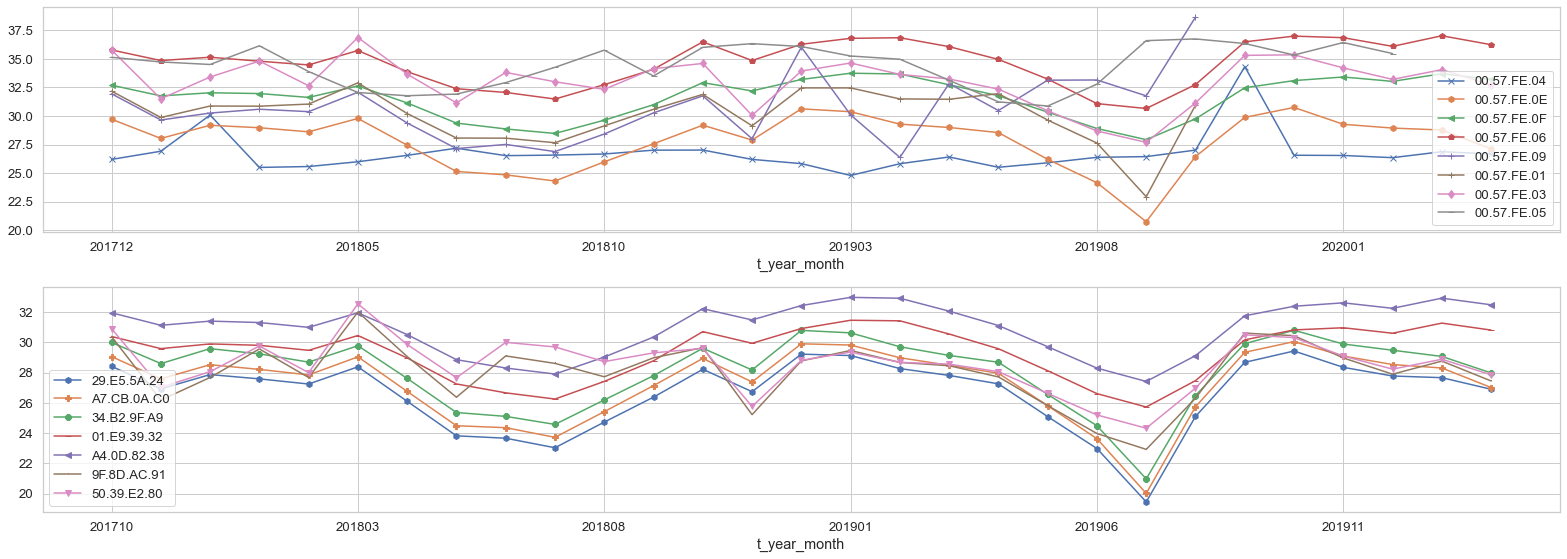

In [4]:
# create valid markers from mpl.markers
valid_markers = ([item[0] for item in mpl.markers.MarkerStyle.markers.items() if
item[1] is not 'nothing' and not item[1].startswith('tick') and not item[1].startswith('caret')])
markers = np.random.choice(valid_markers, df.shape[1], replace=True)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(22,8))
for i, mod in enumerate(df.Module.unique()):
    if '00.' in mod:
        data = df[df['Module']==mod].groupby('t_year_month').mean().dropna(how='all',axis=1)
        data.Temp_Mod.plot(ax=ax1, marker=markers[i], label = mod)
    else:
        data = df[df['Module']==mod].groupby('t_year_month').mean().dropna(how='all',axis=1)
        data.Temp_Mod.plot(ax=ax2, marker=markers[i], label = mod)
ax1.legend()
ax2.legend()
plt.tight_layout()

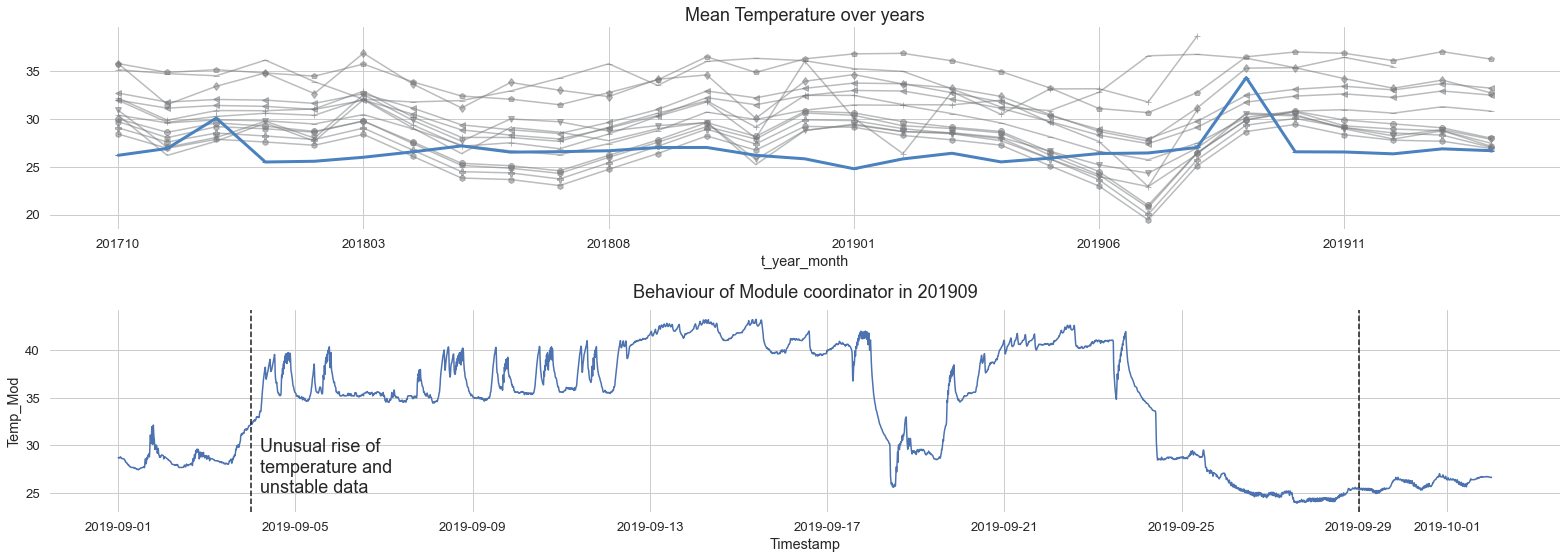

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(22,8))
for i, mod in enumerate(df.Module.unique()):
    if mod != '00.57.FE.04':
        data = df[df['Module']==mod].groupby('t_year_month').mean().dropna(how='all',axis=1)
        data.Temp_Mod.plot(ax=ax1, marker=markers[i], color=colors['GRAY5'], alpha=0.5)

data = df[df['Module']=='00.57.FE.04'].groupby('t_year_month').mean().dropna(how='all',axis=1)
data.Temp_Mod.plot(ax=ax1, label=mod, marker=markers[i], color=colors['BLUE2'], linewidth=3)
        
data = df[df['Module']=='00.57.FE.04'].resample('10Min').mean()
sns.lineplot(data=data['2019-09-01':'2019-10-01']['Temp_Mod'], ax=ax2)
ax1.set_title('Mean Temperature over years', fontsize=18)
ax2.set_title('Behaviour of Module coordinator in 201909', fontsize=18, y=1.03)
ax2.axvline(x = Timestamp("2019-09-04 00:00:00"), color='k', linestyle = '--')
ax2.axvline(x = Timestamp("2019-09-29 00:00:00"), color='k', linestyle = '--')
ax2.annotate('Unusual rise of\ntemperature and\nunstable data', xy=(Timestamp("2019-09-04 05:00:00"), 25), fontsize=18)
remove_chart_borders(ax1)
remove_chart_borders(ax2)
plt.tight_layout()

In [6]:
data = pd.concat([df[df['Module'] == '00.57.FE.01'].dropna(axis=1, how='all').Temp_Mod,
                  df[df['Module'] == '00.57.FE.0E'].dropna(axis=1, how='all').Temp_Mod,
                  df[df['Module'] == '00.57.FE.09'].dropna(axis=1, how='all').Temp_Mod,
                  df[df['Module'] == '29.E5.5A.24'].dropna(axis=1, how='all').Temp_Mod,
                  df[df['Module'] == '29.E5.5A.24'].dropna(axis=1, how='all')['PT100(0)'],
                  df[df['Module'] == '9F.8D.AC.91'].dropna(axis=1, how='all').Temp_Mod, 
                  df[df['Module'] == '00.57.FE.03'].dropna(axis=1, how='all').Temp_Mod,
                  df[df['Module'] == 'A4.0D.82.38'].dropna(axis=1, how='all').Temp_Mod,
                  df[df['Module'] == '00.57.FE.0F'].dropna(axis=1, how='all').Temp_Mod,
                  df[df['Module'] == '01.E9.39.32'].dropna(axis=1, how='all').Temp_Mod
                 ],
                 axis=1).resample('10Min').mean()
mod_list = ['00.57.FE.01', '00.57.FE.0E', '00.57.FE.09', '29.E5.5A.24', '29.E5.5A.24',
            '9F.8D.AC.91', '00.57.FE.03', 'A4.0D.82.38', '00.57.FE.0F', '01.E9.39.32']

In [7]:
data.columns = ['00.57.FE.01(R4)', '00.57.FE.0E(R5)', '00.57.FE.09(R1)', '29.E5.5A.24(Sensor)','PT100(Sensor)',
               '9F.8D.AC.91(TE_Sensor)', '00.57.FE.03(R2)', 'A4.0D.82.38(PD_Sensor)', '00.57.FE.0F(R6)', '01.E9.39.32(PD_Sensor)']

### Wavelet Transform of Non Power Data
The wavelet transform of a 1D signal results in a 2D scaleogram which contains a lot more information than just the time-series or just the Fourier Transform.

Such a scaleogram can not only be used to better understand the dynamical behavior of a system, but it can also be used to distinguish different types of signals produced by a system from each other. If you record a signal while you are walking up the stairs or down the stairs, the scaleograms will look different. ECG measurements of people with a healthy heart will have different scaleograms than ECG measurements of people with arrhythmia. Or measurements on a bearing, motor, rotor, ventilator, etc when it is faulty vs when it not faulty.

So by looking at the scaleograms we can distinguish a broken motor from a working one, a healthy person from a sick one, a person walking up the stairs from a person walking down the stairs, etc etc. But if you are as lazy as me, you probably don’t want to sift through thousands of scaleograms manually. One way to automate this process is to build a Convolutional Neural Network which can automatically detect the class each scaleogram belongs to and classify them accordingly.

In [8]:
import pywt
from scipy.fftpack import fft
from scipy import signal
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from scipy.signal import welch
import scaleogram as scg

from utils import plot_wavelet, wavelet_transform
from matplotlib.colors import ListedColormap

cmaps = ['twilight_shifted', 'coolwarm', 'seismic']

wavelet_families = pywt.families(short=False)
discrete_mother_wavelets = pywt.wavelist(kind='discrete')
continuous_mother_wavelets = pywt.wavelist(kind='continuous')
print("PyWavelets contains the following Continuous families: ")
print(continuous_mother_wavelets,'\n')

PyWavelets contains the following Continuous families: 
['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan'] 



In [9]:
from utils import plot_scaleogram

### **MOD 04 Coordinator**

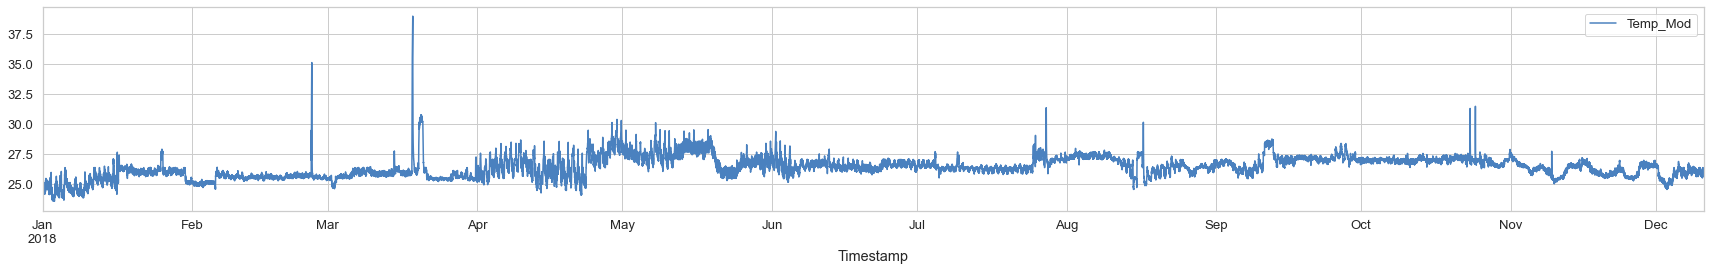

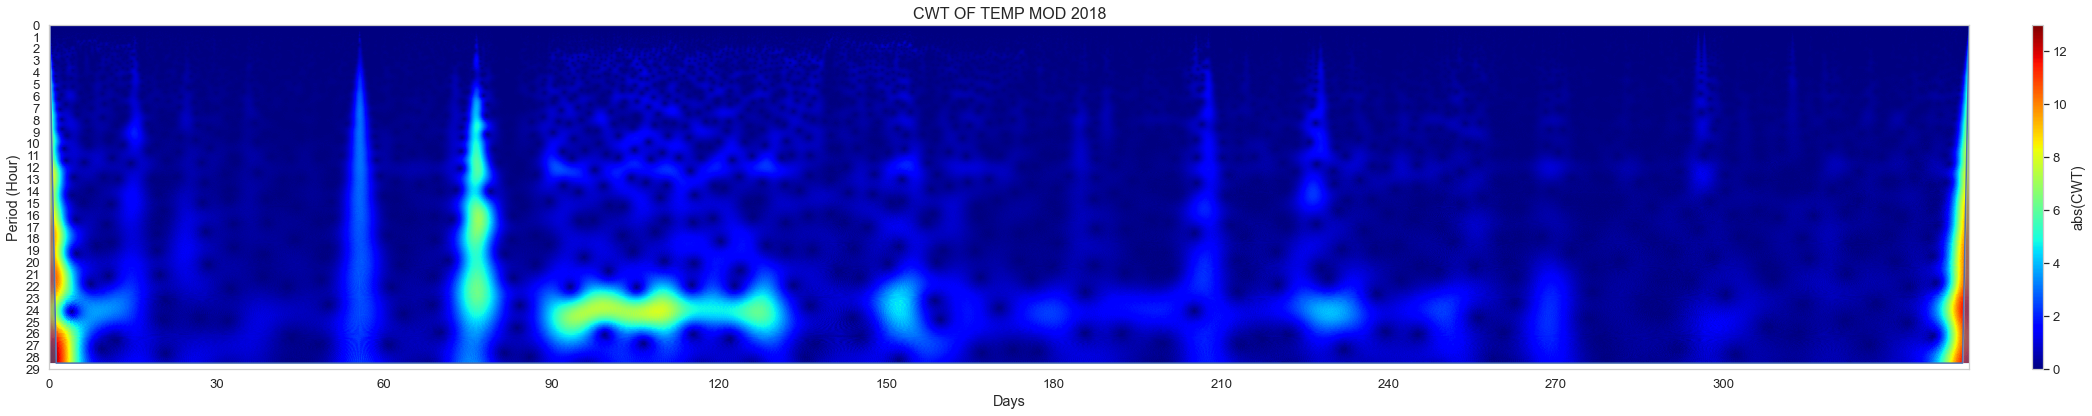

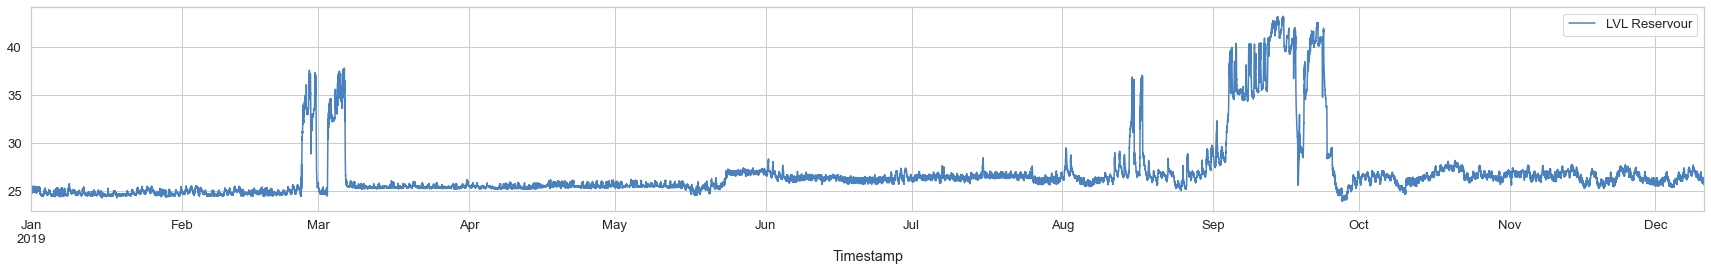

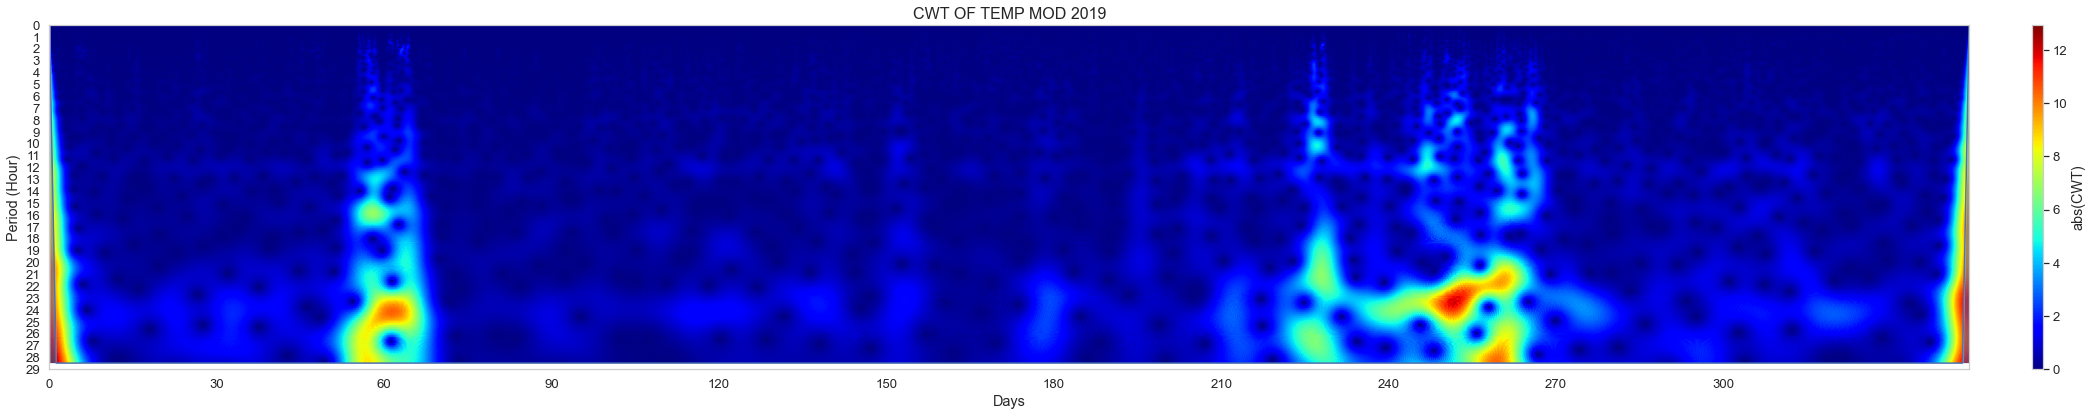

In [10]:
data = df[df['Module'] == '00.57.FE.04'].dropna(axis=1, how='all').resample('5Min').mean()

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(24,4))
data['Temp_Mod']['2018-01-01':'2018-12-10'].plot(ax=ax1, color=colors['BLUE2'])
ax1.legend()
plt.tight_layout()

wavelet='cmor8-1.5'
ax1 = plot_scaleogram(data['Temp_Mod']['2018-01-01':'2018-12-10'].interpolate(), resample_time = 5, wavelet='cmor8-1.5',
                      scales=np.arange(1, 512), xlabel='Days', ylabel='Period (Hour)',
                      plot_signal=False, figsize=(30,6), monthly=True)
ax1.set_title('CWT OF TEMP MOD 2018', fontsize=16, y=1.03); 

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(24,4))
data['Temp_Mod']['2019-01-01':'2019-12-10'].plot(ax=ax1, label='LVL Reservour', color=colors['BLUE2'])
ax1.legend()
plt.tight_layout()

ax1 = plot_scaleogram(data['Temp_Mod']['2019-01-01':'2019-12-10'].interpolate(), resample_time = 5, wavelet='cmor8-1.5',
                      scales=np.arange(1, 512), xlabel='Days', ylabel='Period (Hour)',
                      plot_signal=False, figsize=(30,6), monthly=True)
ax1.set_title('CWT OF TEMP MOD 2019', fontsize=16, y=1.03); 
plt.show()

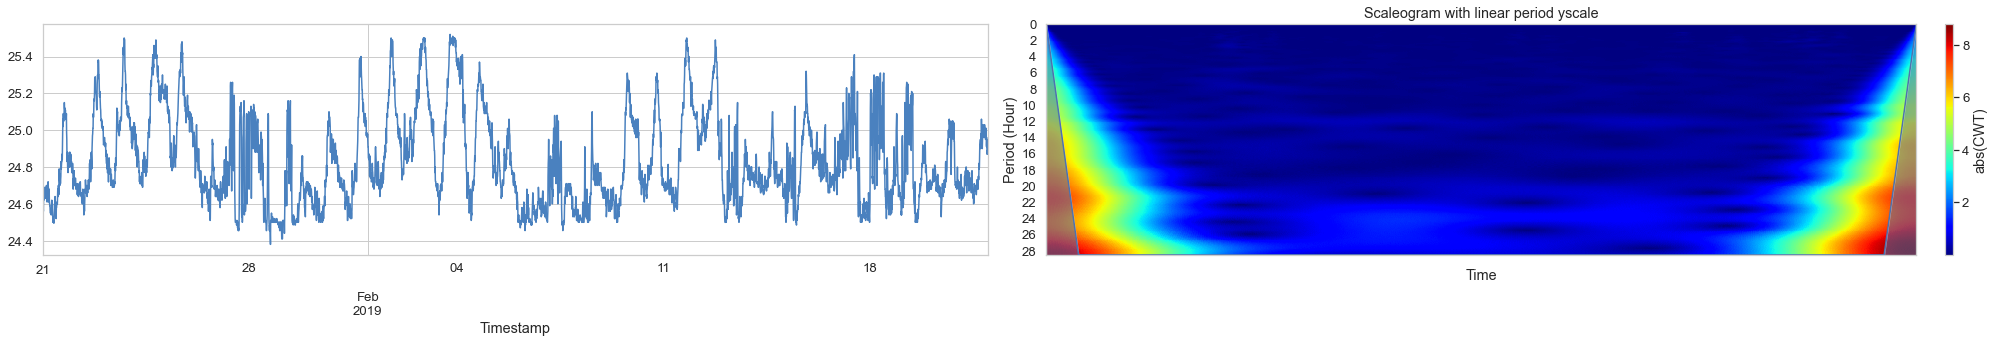

In [11]:
wavelet='cmor8-1.5'

signal = df[df['Module'] == '00.57.FE.04']['Temp_Mod'].resample('10Min').mean().interpolate()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-01-21':'2019-02-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-01-21':'2019-02-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

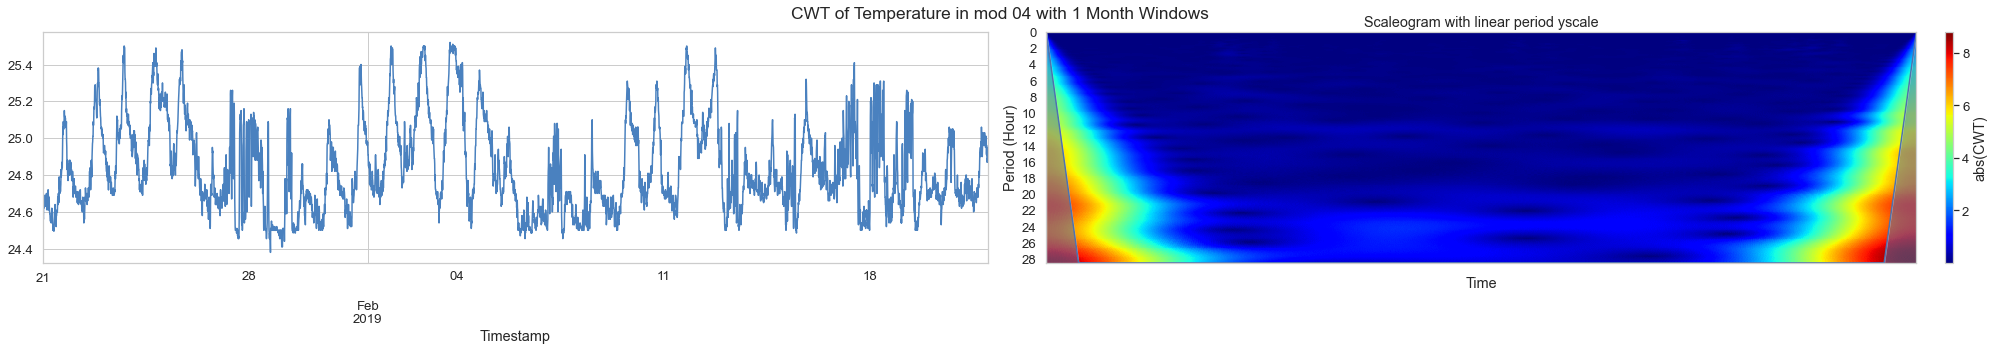

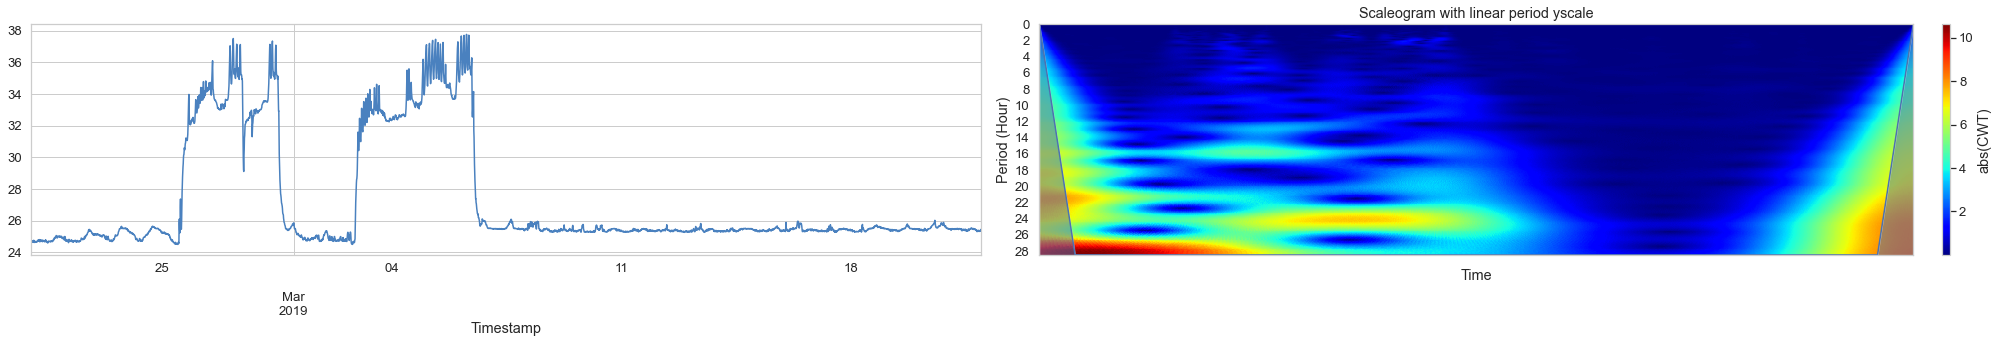

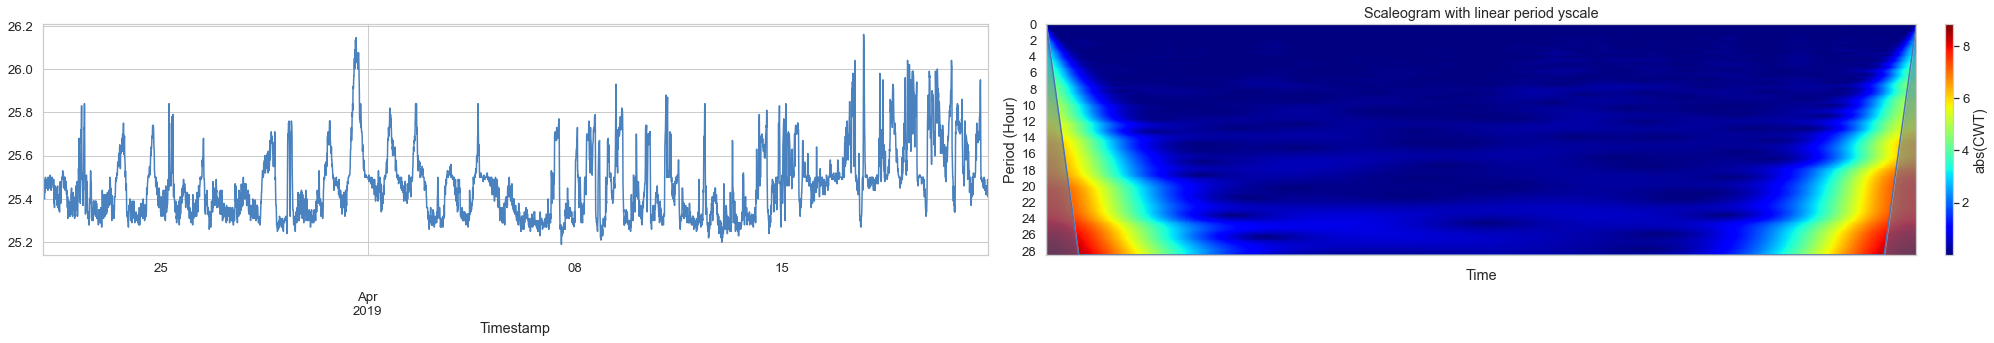

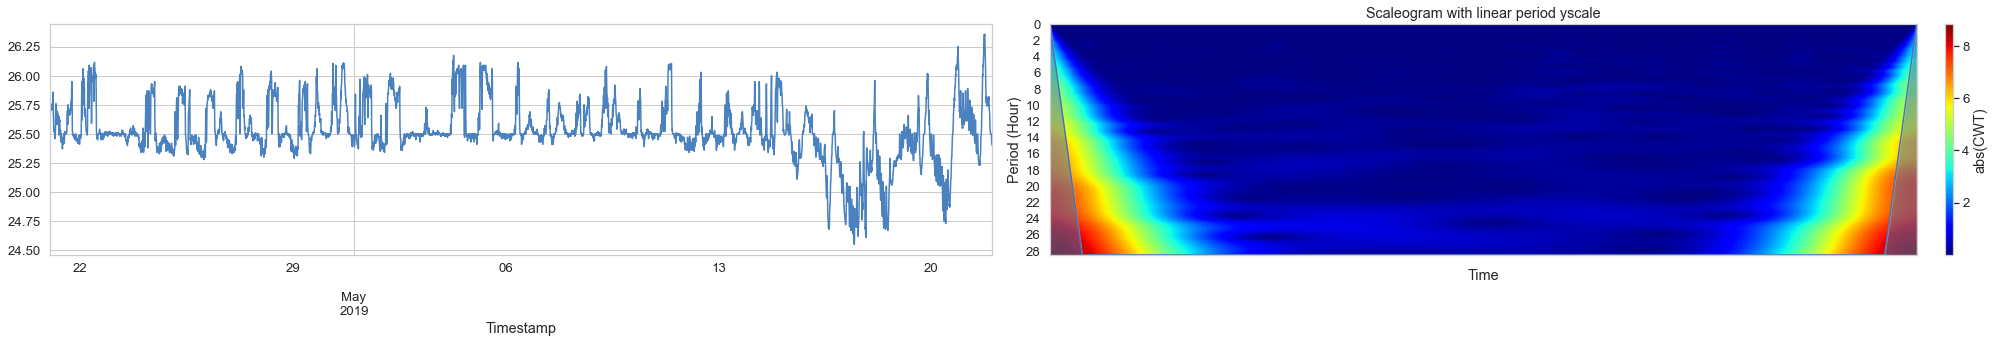

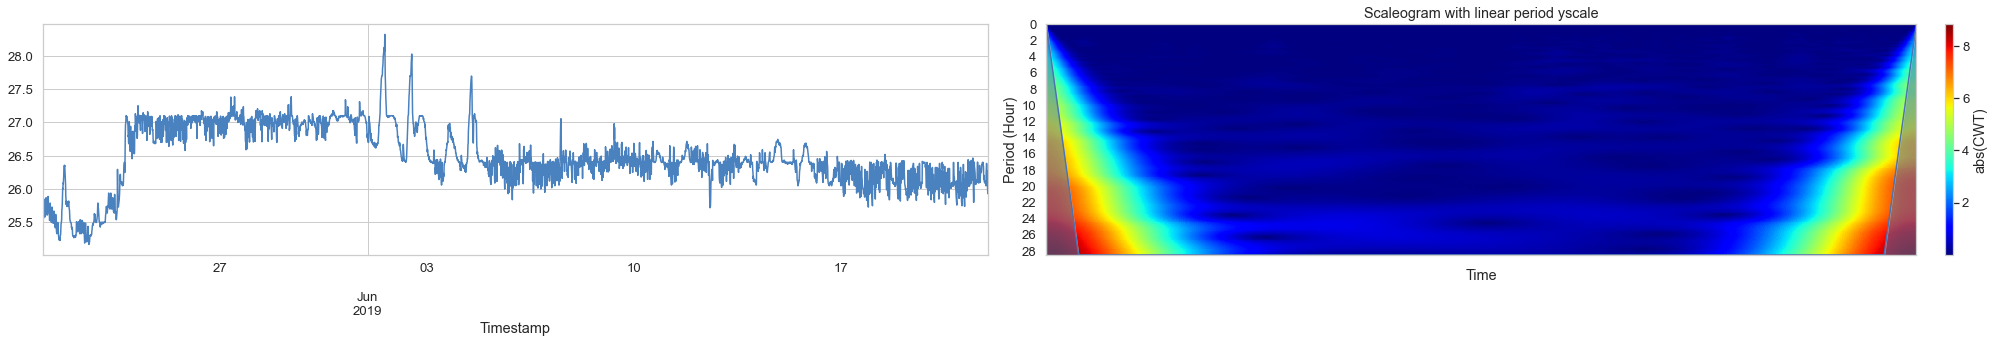

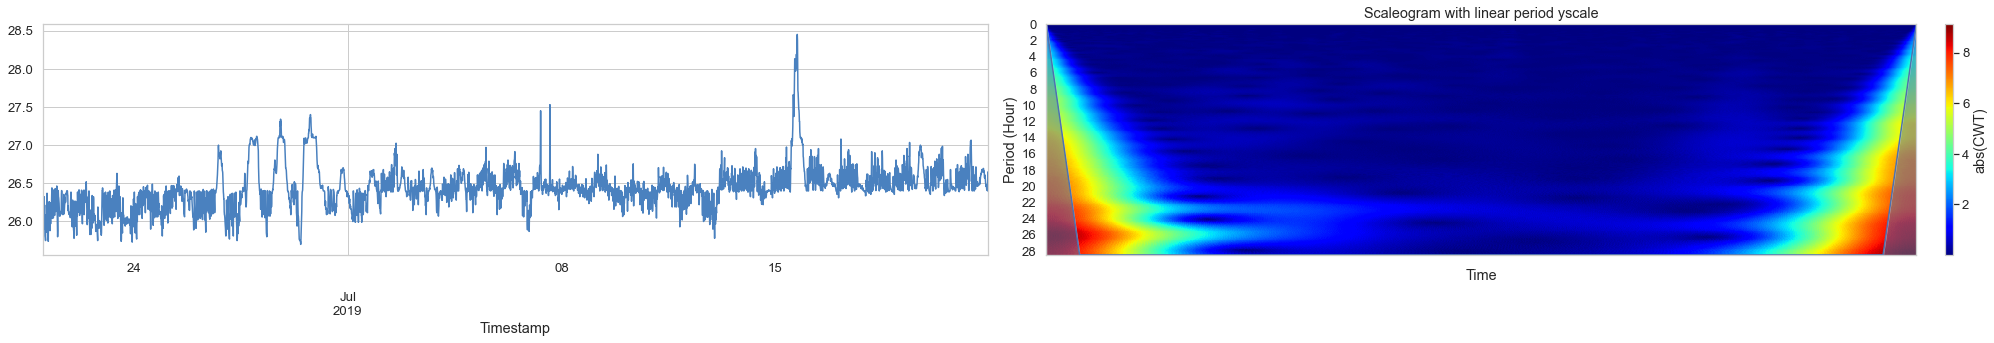

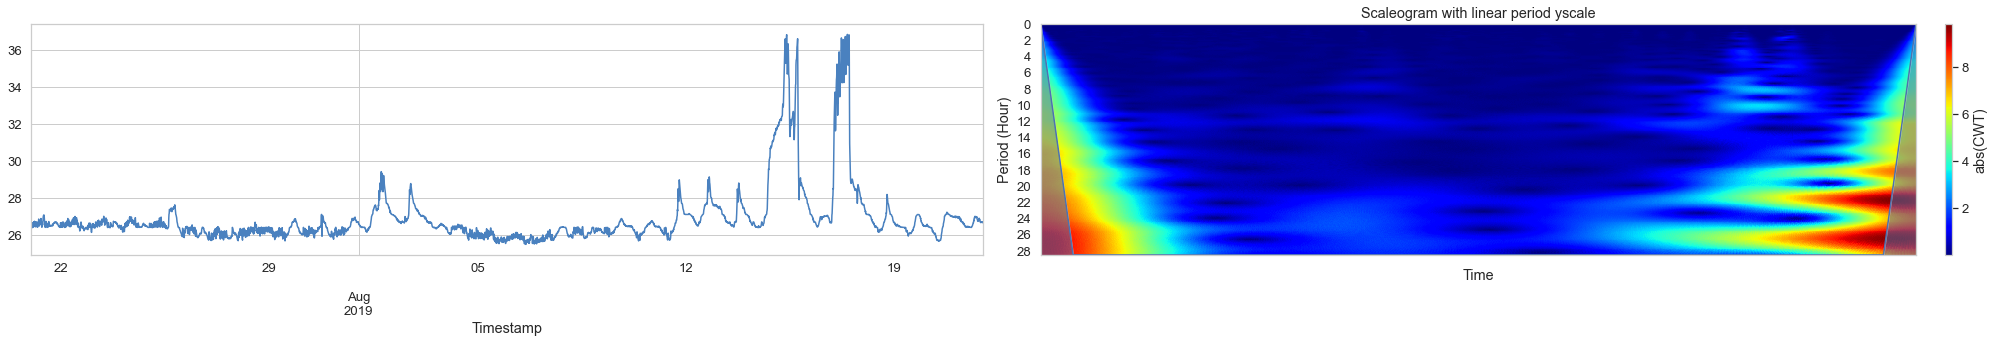

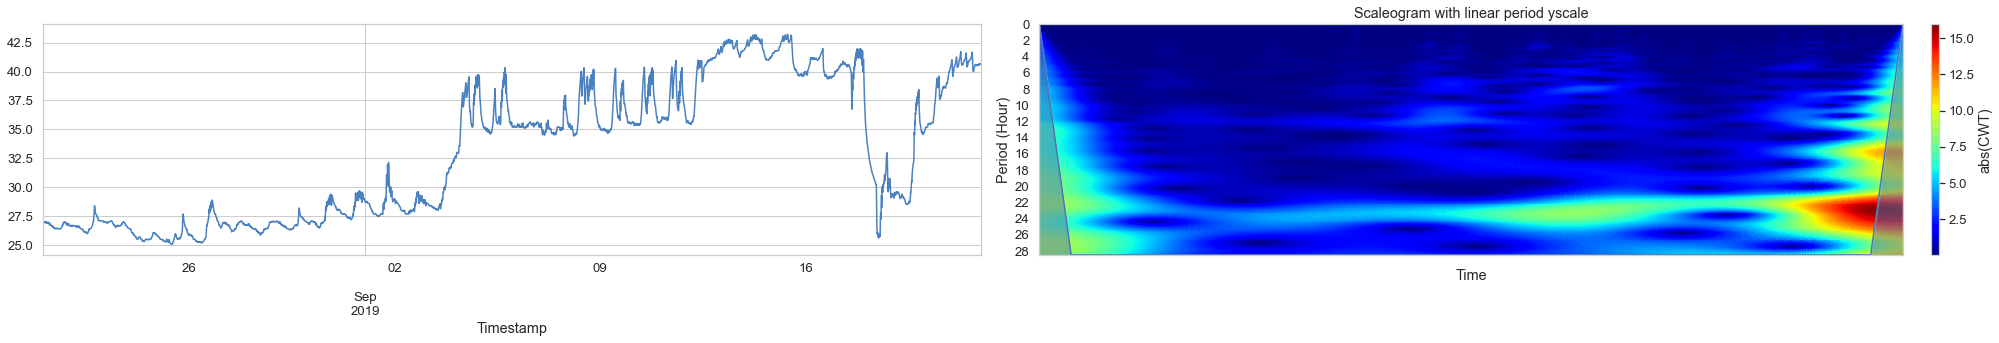

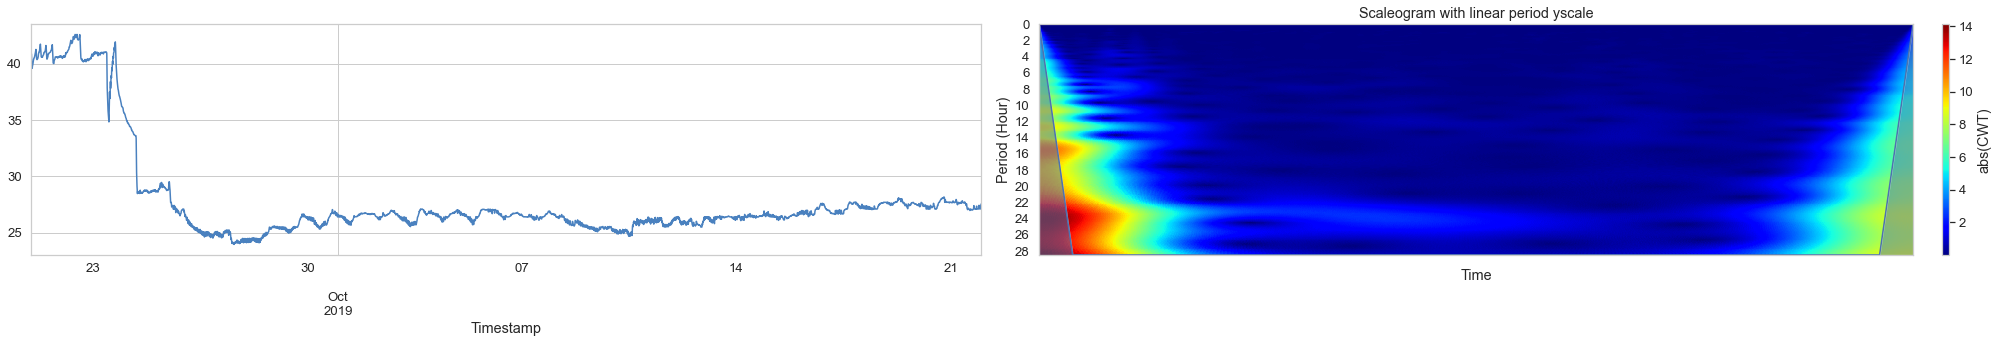

In [12]:
wavelet='cmor8-1.5'

signal = df[df['Module'] == '00.57.FE.04']['Temp_Mod'].resample('10Min').mean().interpolate()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-01-21':'2019-02-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-01-21':'2019-02-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
fig.suptitle('CWT of Temperature in mod 04 with 1 Month Windows')
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-02-21':'2019-03-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-02-21':'2019-03-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-03-21':'2019-04-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-03-21':'2019-04-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-04-21':'2019-05-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-03-21':'2019-04-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-05-21':'2019-06-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-03-21':'2019-04-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-06-21':'2019-07-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-06-21':'2019-07-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-07-21':'2019-08-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-07-21':'2019-08-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-08-21':'2019-09-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-08-21':'2019-09-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-09-21':'2019-10-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal['2019-09-21':'2019-10-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

## Create Wavelet Dataset

The idea is to detect anomalies using CWT (scaleograms). First we have to create the dataset, to do this we have to slice the time series into windows of a defined size. A good size may be 2-3 months with with overlapping of 1 month. We need to see the size of the resulting dataset. Then we can try different algorithms like Autoencoders.

We can see in that the normal temperature of the radio is around 25 degrees. Strong spikes and oscilations are seen with stronger colors in the scaleogram.

We will start using the 1 months windows with one month of overlapping. The timestamp defines how many points between segments.

In [13]:
print('Length of 2 months {}'.format(signal['2019-06-21':'2019-08-21'].shape[0]))
# take 1 month
timesteps = int(signal['2019-06-21':'2019-08-21'].shape[0] / 2)

Length of 2 months 8928


In [14]:
# Create training data
signal = df[df['Module'] == '00.57.FE.04'][['Temp_Mod']].resample('10Min').mean()

#scaler = MinMaxScaler()
#signal_scaled = pd.DataFrame(data = scaler.fit_transform(signal), index = signal.index, columns=['Temp'])

X_train = signal['2018-01':'2019-07-21']
X_test = signal['2019-07-22':]

In [15]:
def create_segments(df, timesteps, step):
    
    segments = []
    n_features = df.shape[1]
    cols = df.columns
    timesteps = int(timesteps)
    step = int(step)
    
    for i in range(0, len(df) - timesteps, step):
        serie = df[cols[0]].values[i: i + timesteps]
        segments.append([serie])
    
    # Current shape is (Samples, N Features, Time segments)
    # Bring the segments into a better shape (Samples, time_segments, N features)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, timesteps, n_features)
    
    return reshaped_segments

In [16]:
X_train_seg = create_segments(X_train, timesteps, timesteps/2)
X_test_seg = create_segments(X_test, timesteps, timesteps/2)
print(X_train_seg.shape)
print(X_test_seg.shape)

(35, 4464, 1)
(12, 4464, 1)


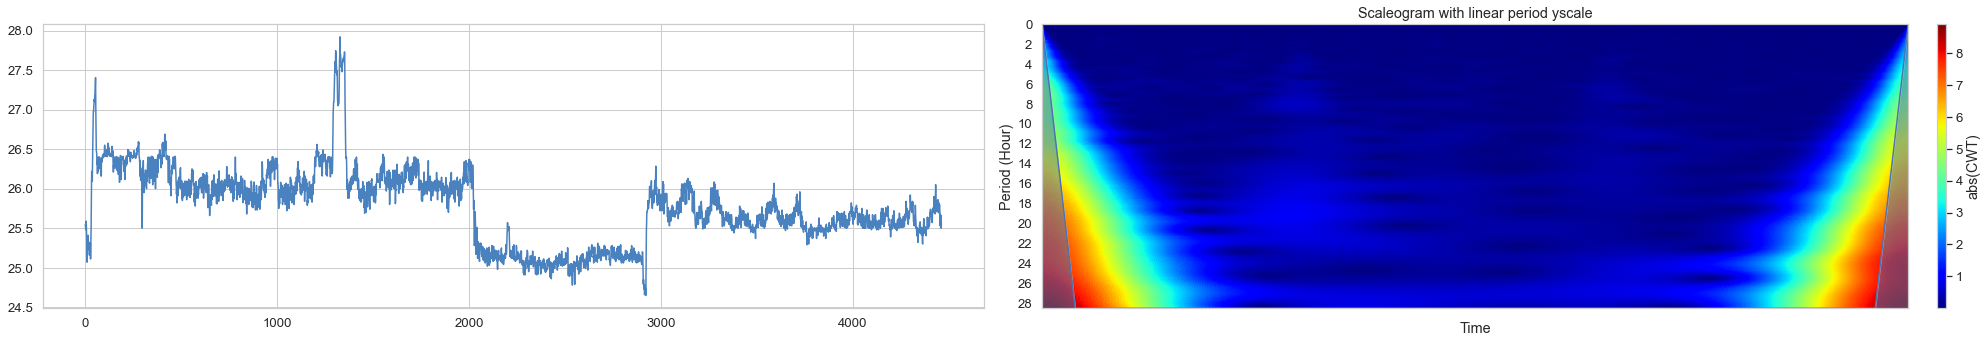

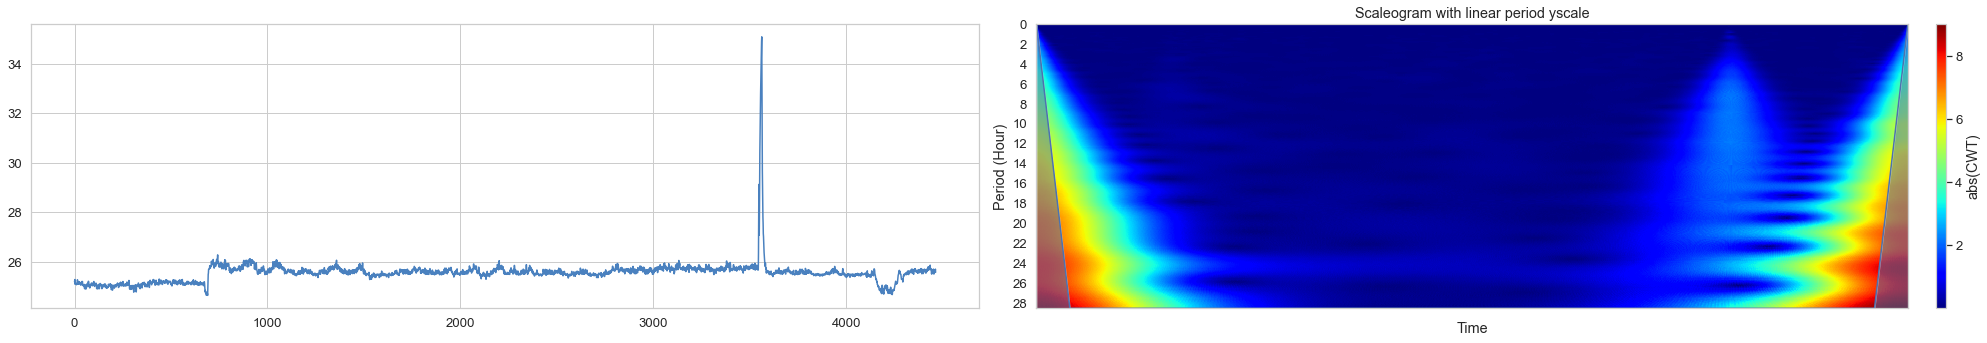

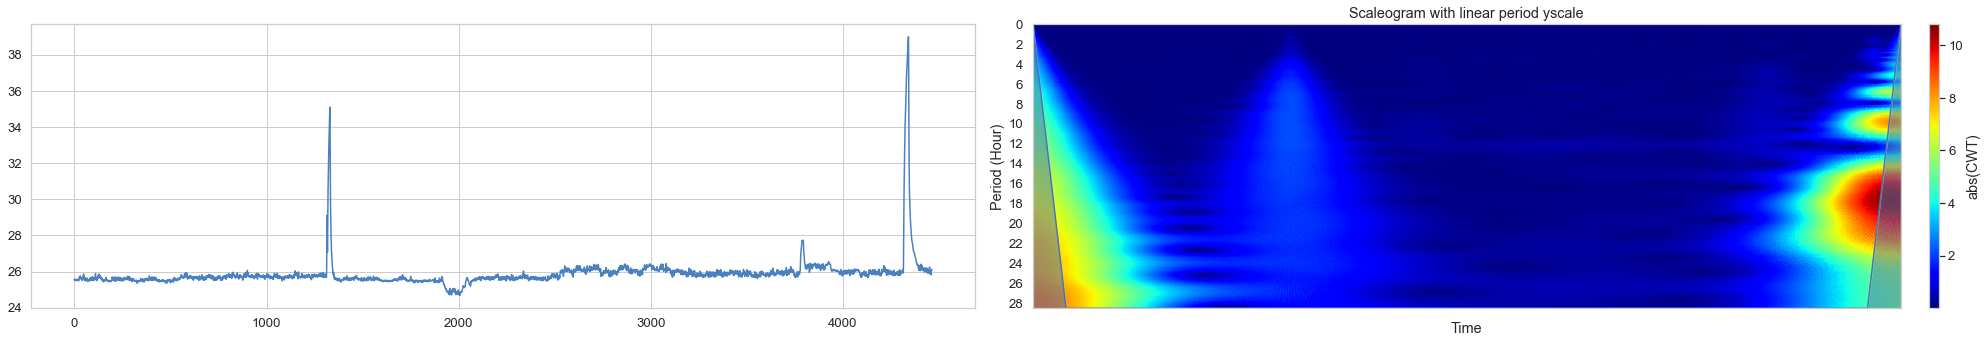

In [17]:
for ii in np.arange(1, 4):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
    ax1.plot(X_train_seg[ii,:,:].reshape(-1), color=colors['BLUE2'])
    plot_scaleogram(X_train_seg[ii,:,:].reshape(-1), resample_time = 10, wavelet='cmor8-1.5',
                    scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                    plot_signal=False, ax1=ax2)

### Save images to disk

In [49]:
import matplotlib.image as mpimg
import cv2
from PIL import Image

In [223]:
for ii in np.arange(0, X_train_seg.shape[0]):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
    plot_scaleogram(X_train_seg[ii,:,:].reshape(-1), resample_time = 10, wavelet='cmor8-1.5',
                    scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                    plot_signal=False, ax1=ax1)
    ax1.set_ylabel(''); ax1.set_xlabel('');ax1.set_title('')
    plt.savefig('../Data/train_images/cwt_{}'.format(ii))
    plt.close()

In [224]:
for ii in np.arange(0, X_test_seg.shape[0]):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
    plot_scaleogram(X_train_seg[ii,:,:].reshape(-1), resample_time = 10, wavelet='cmor8-1.5',
                    scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                    plot_signal=False, ax1=ax1)
    ax1.set_ylabel(''); ax1.set_xlabel('');ax1.set_title('')
    plt.savefig('../Data/test_images/cwt_{}'.format(ii))
    plt.close()

#### Reshape images, convert to RGB and save images

In [225]:
path = '../Data/train_images/'

for i in np.arange(0, X_train_seg.shape[0]):
    image = Image.open(str(path)+'cwt_'+str(i)+'.png')
    image = image.resize((64, 64))
    image = image.convert('RGB')
    image.save(str(path)+'cwt_'+str(i)+'.png')

### Load images

In [226]:
from pathlib import Path
from matplotlib import image
import os

In [227]:
path = Path('../Data/train_images/')

image_names = os.listdir(path)[1:]
print('There are {} images in folder'.format(len(image_names)))
print('Examples are: \n-------\n', image_names[:3])

There are 35 images in folder
Examples are: 
-------
 ['cwt_0.png', 'cwt_1.png', 'cwt_10.png']


In [228]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

In [229]:
train_images = []
for name in image_names:
    # opne images using Pillow and convert to array with numpy
    train_image = Image.open(path/name)
    train_image = np.asarray(train_image)
    train_images.append(train_image)
    
x_train = np.array(train_images)
x_train = x_train/255
print('{} images of dimensions {}x{}x{}'.format(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3]))

35 images of dimensions 64x64x3


In [230]:
x_dim = x_train.shape[1]
y_dim = x_train.shape[2]
channels = x_train.shape[3]
BATCH_SIZE = 32
EPOCHS = 50

# ENCODER
input_img = Input(shape=(x_dim, y_dim, channels))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

In [231]:
history = autoencoder.fit(x_train, x_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose=2)

Epoch 1/50
2/2 - 3s - loss: 0.6926
Epoch 2/50
2/2 - 1s - loss: 0.6439
Epoch 3/50
2/2 - 1s - loss: 0.5404
Epoch 4/50
2/2 - 1s - loss: 0.4234
Epoch 5/50
2/2 - 2s - loss: 0.3800
Epoch 6/50
2/2 - 2s - loss: 0.3752
Epoch 7/50
2/2 - 2s - loss: 0.3984
Epoch 8/50
2/2 - 2s - loss: 0.3573
Epoch 9/50
2/2 - 2s - loss: 0.3484
Epoch 10/50
2/2 - 1s - loss: 0.3155
Epoch 11/50
2/2 - 2s - loss: 0.3151
Epoch 12/50
2/2 - 2s - loss: 0.3024
Epoch 13/50
2/2 - 2s - loss: 0.2863
Epoch 14/50
2/2 - 2s - loss: 0.2793
Epoch 15/50
2/2 - 2s - loss: 0.2652
Epoch 16/50
2/2 - 2s - loss: 0.2588
Epoch 17/50
2/2 - 2s - loss: 0.2544
Epoch 18/50
2/2 - 1s - loss: 0.2448
Epoch 19/50
2/2 - 1s - loss: 0.2394
Epoch 20/50
2/2 - 2s - loss: 0.2376
Epoch 21/50
2/2 - 2s - loss: 0.2295
Epoch 22/50
2/2 - 2s - loss: 0.2264
Epoch 23/50
2/2 - 2s - loss: 0.2227
Epoch 24/50
2/2 - 2s - loss: 0.2173
Epoch 25/50
2/2 - 2s - loss: 0.2130
Epoch 26/50
2/2 - 1s - loss: 0.2099
Epoch 27/50
2/2 - 2s - loss: 0.2091
Epoch 28/50
2/2 - 2s - loss: 0.2035
E

In [232]:
latent_img = encoder.predict(x_train[0,:,:,:].reshape((-1,64,64,3)))

In [235]:
latent_img.shape

(1, 8, 8, 32)

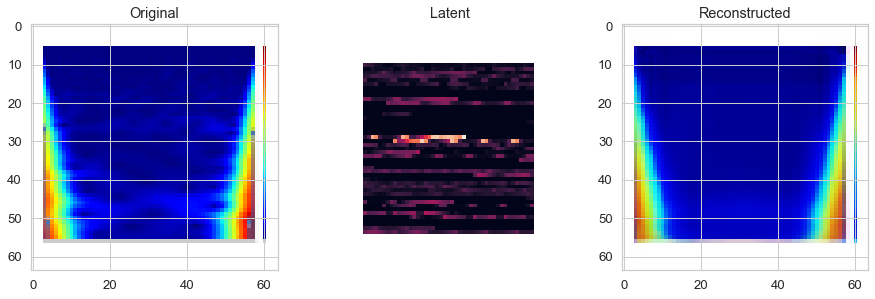

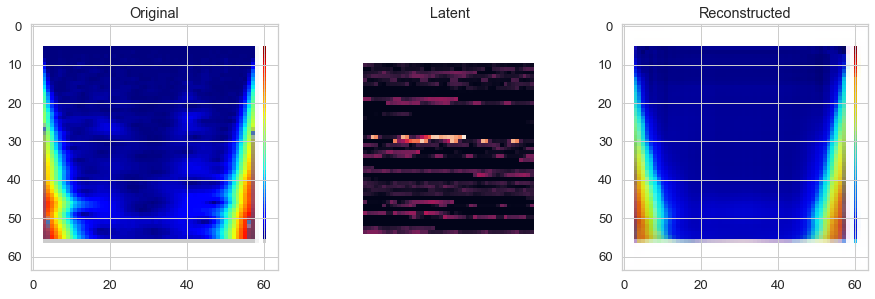

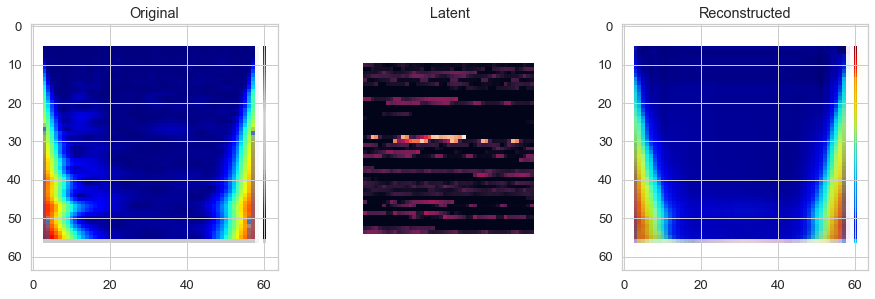

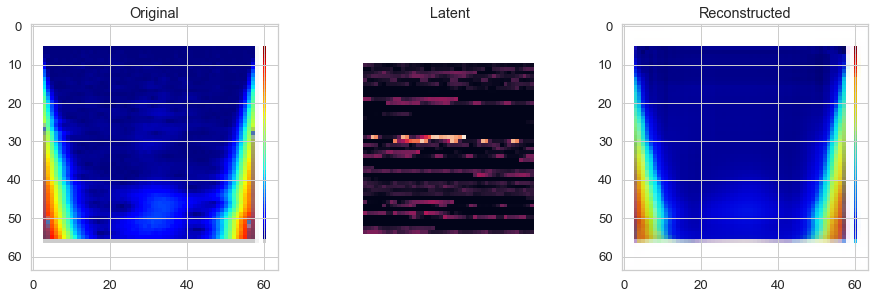

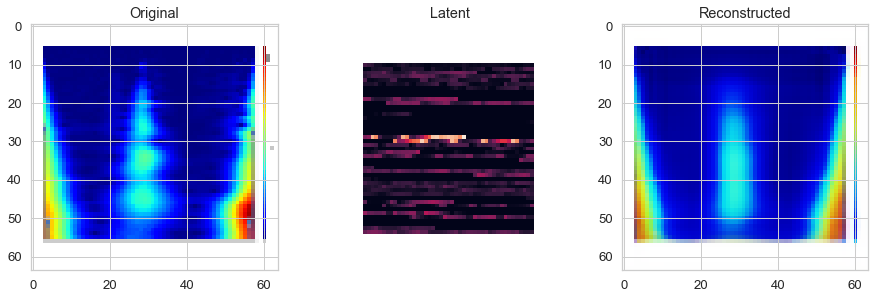

In [233]:
for i in np.arange(25,30):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = x_train[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

# Wavelet analysis of features

## Oil Temperature

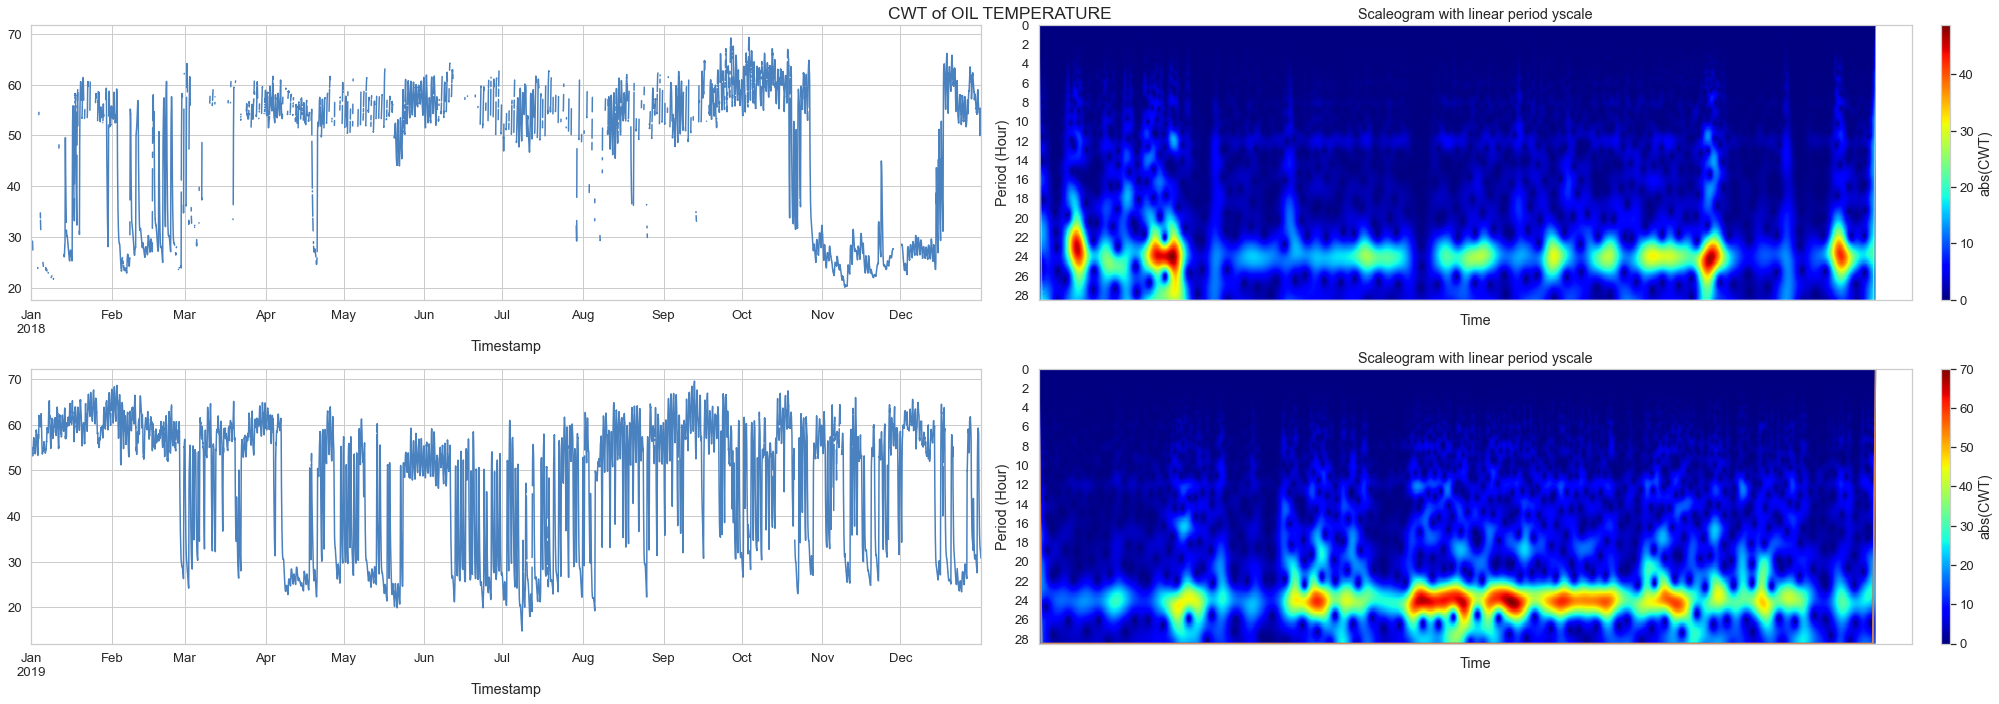

In [38]:
signal = df[df['Module'] == '9F.8D.AC.91'].Temp_Oil.resample('10Min').mean()

fig, axx = plt.subplots(nrows=2, ncols=2, figsize=(28,10))
signal['2018-01-01':'2018-12'].plot(ax=axx[0,0], color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2018-01-01':'2018-12'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=axx[0,1])

signal['2019-01-01':'2019-12'].plot(ax=axx[1,0], color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2019-01-01':'2019-12'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=axx[1,1])

fig.suptitle('CWT of OIL TEMPERATURE')
plt.tight_layout()

## Drain Water Level Sensor

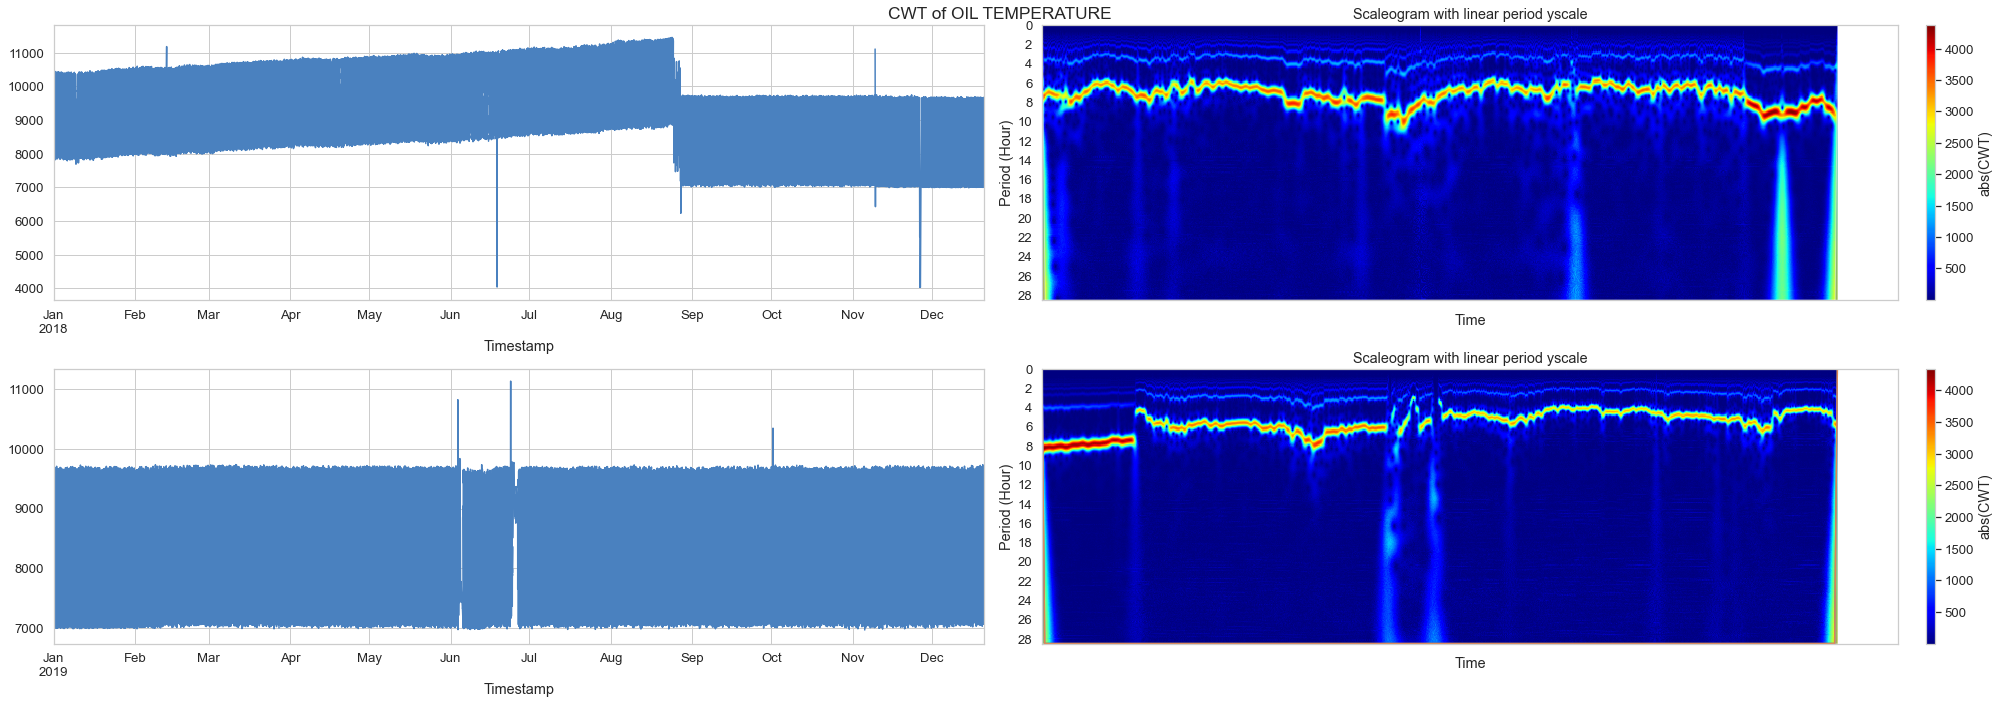

In [40]:
signal = df[df['Module'] == '01.E9.39.32']['LVL_Drain(1)'].resample('10Min').mean()

fig, axx = plt.subplots(nrows=2, ncols=2, figsize=(28,10))
signal['2018-01-01':'2018-12-20'].plot(ax=axx[0,0], color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2018-01-01':'2018-12-20'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=axx[0,1])

signal['2019-01-01':'2019-12-20'].plot(ax=axx[1,0], color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2019-01-01':'2019-12-20'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=axx[1,1])

fig.suptitle('CWT of OIL TEMPERATURE')
plt.tight_layout()

### Water Level in abnormal locations

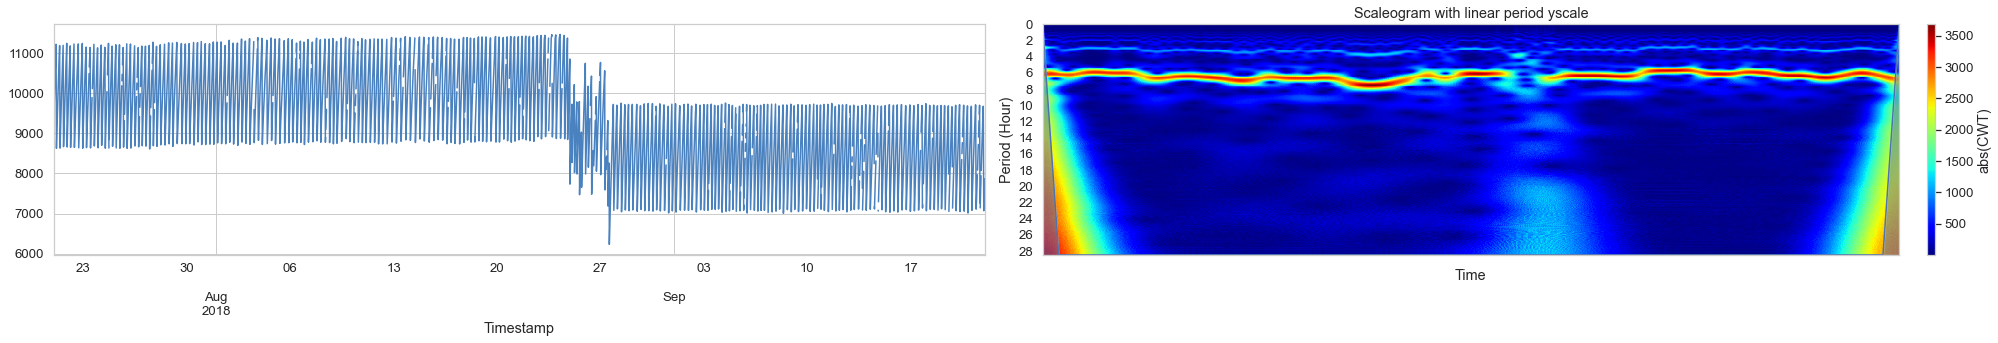

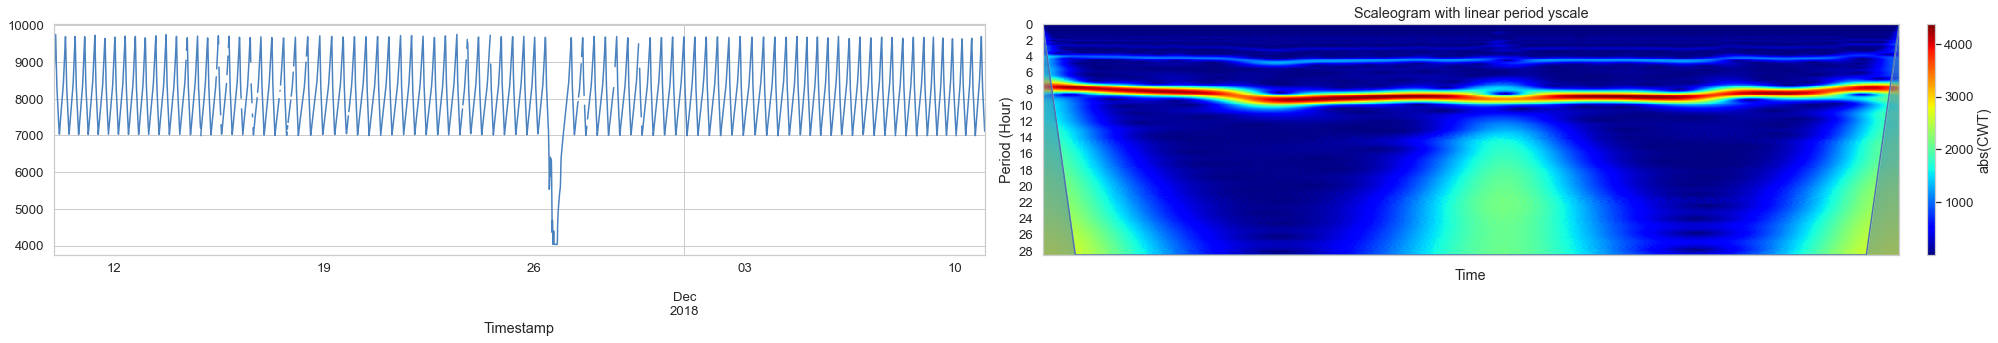

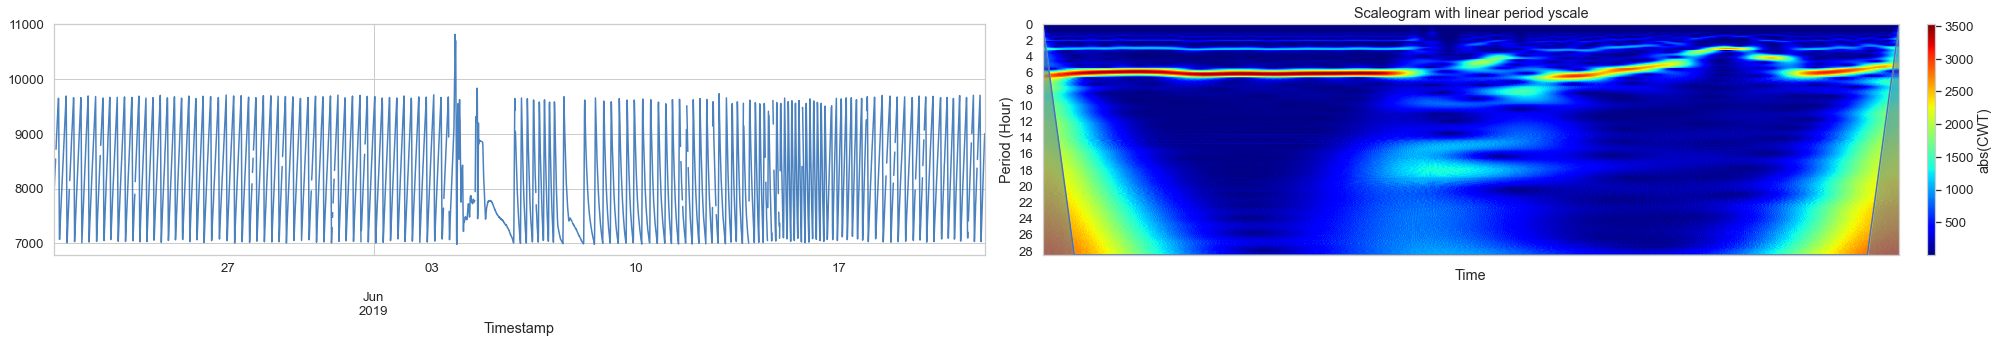

In [51]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2018-07-21':'2018-09-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2018-07-21':'2018-09-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2018-11-10':'2018-12-10'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2018-11-10':'2018-12-10'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-05-21':'2019-06-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2019-05-21':'2019-06-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

## Solar Panel Sensor

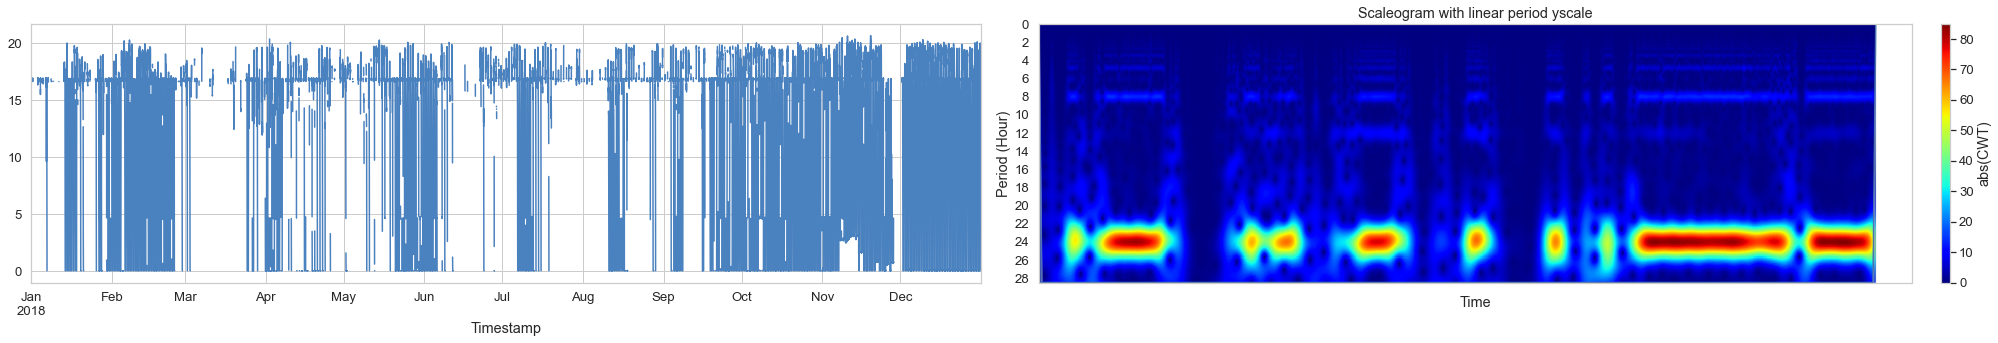

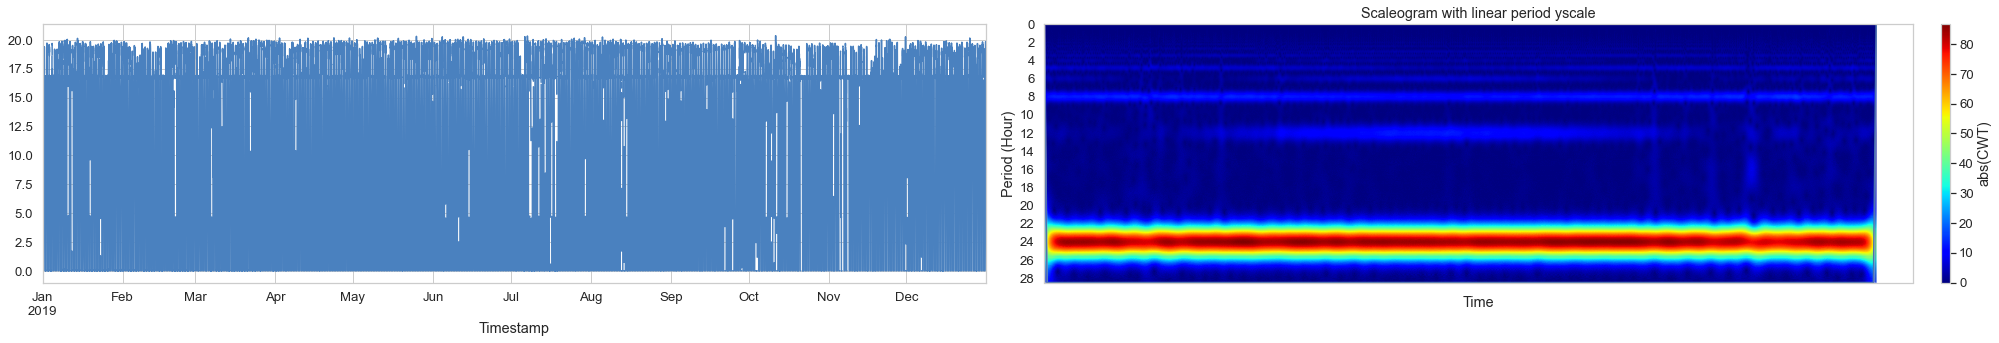

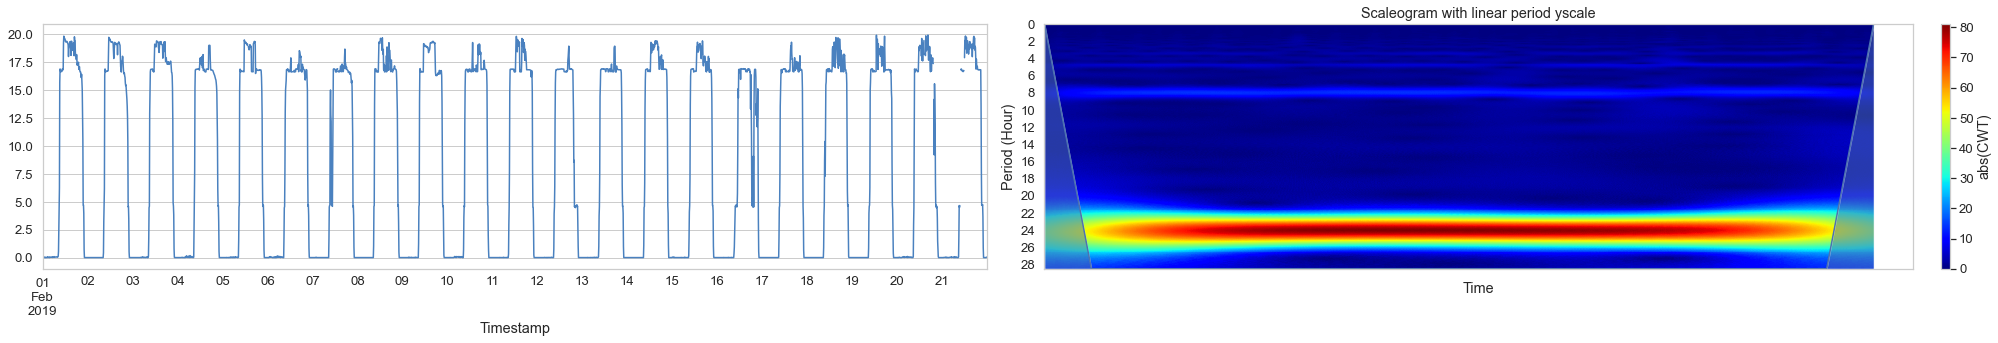

In [53]:
signal = df[df['Module'] == '50.39.E2.80']['V_Panel_TE'].resample('10Min').mean()

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2018-01-01':'2018-12'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2018-01-01':'2018-12'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-01-01':'2019-12'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2019-01-01':'2019-12'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28,5))
signal['2019-02-01':'2019-02-21'].plot(ax=ax1, color=colors['BLUE2'])
plot_scaleogram(signal.interpolate()['2019-02-01':'2019-02-21'], resample_time = 10, wavelet='cmor8-1.5',
                scales=np.arange(1, 256), xlabel='Days', ylabel='Period (Hour)', 
                plot_signal=False, ax1=ax2)
plt.tight_layout()